<a href="https://colab.research.google.com/github/francesco-source/Machine-Learning/blob/main/Clustering_17_02_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering exam of the 17/02/2021

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.metrics import silhouette_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler ,OneHotEncoder, OrdinalEncoder
from sklearn.metrics.cluster import pair_confusion_matrix
random_state = 42

##1. Load th data, show the shape and for each column show the frequencies of each distinct value.

In [65]:
data = pd.read_csv("exam_2021_02_17_data.csv",sep = "\t",header = None)
data.head()

,0,1,2
0,F0,F1,F2
1,d,a,a
2,c,e,c
3,j,a,c
4,f,e,j


In [66]:
print("The shape of the dataset is equal to: ",data.shape)
print("The size of the dataset is equal to: ",data.size)
for column in data.columns:
  values, counts = np.unique (data[column],return_counts = True)
  print("In the column ",column," the unique values are: ",values)
  print("In the column ",column," the counts are: ",counts)


The shape of the dataset is equal to:  (1001, 3)
The size of the dataset is equal to:  3003
In the column  0  the unique values are:  ['F0' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
In the column  0  the counts are:  [  1 100 100 100 100 100 100 100 100 100 100]
In the column  1  the unique values are:  ['F1' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
In the column  1  the counts are:  [  1 100  99 100 100 101 100 100 100 100 100]
In the column  2  the unique values are:  ['F2' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
In the column  2  the counts are:  [  1 100  99 100 100 101 100 100 100 100 100]


##2. Do an appropriate preprocessing. The values are considered Nominal. 

In [67]:
ohe = OneHotEncoder(dtype = int,sparse = False)
df = ohe.fit_transform(data)

df = pd.DataFrame(df)
X = df

##3. Choose a clustering scheme and fit it.


I choose k-means

In [68]:
n_clusters = range(2,11)

silhouette_scores = []

inertia = []

size_deviations = []

for cluster in  n_clusters:
  km = KMeans(n_clusters = cluster, random_state = random_state)

  y = km.fit_predict(X)

  silhouette_scores.append(silhouette_score(X,y))

  inertia.append(km.inertia_)

  size_deviations.append(np.sqrt(np.unique(y,return_counts=True)[1].var())/cluster)
  

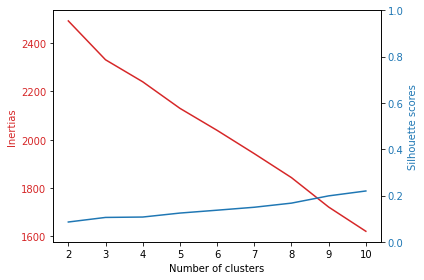

In [69]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


two_plots(x=n_clusters, y1=inertia, y2=silhouette_scores
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

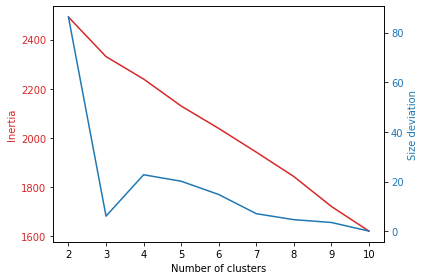

In [70]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

two_plots(x=n_clusters, y1=inertia, y2=size_deviations
          , xlabel='Number of clusters', y1label='Inertia', y2label='Size deviation'
         )

The best number of clusters is equal to 3.

In [71]:
# best cluster possible
k = 3

km_b = KMeans(n_clusters = k , random_state = random_state)

y_km = km_b.fit_predict(X)

##4. Choose another clustering scheme and try to reproduce the same number of clusters that you have coosen in the previuos step.

Now I choose DBSCAN

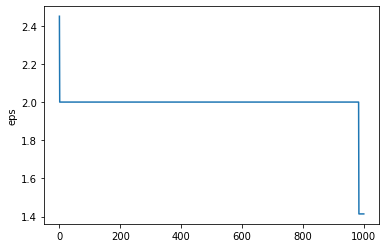

In [72]:
min_points=2*X.shape[1]
k_distances = []
for i in range(0, X.shape[0]):
    k_point_distances = []
    for j in range(0, X.shape[0]):
        if i!=j:
            dist = np.sqrt(sum((X.values[i,:]-X.values[j,:])**2))
            k_point_distances.append(dist)
    k_point_distances.sort()
    k_distances.append(k_point_distances[min_points-1])
    
k_distances.sort(reverse=True)
plt.plot(range(0,len(k_distances)), k_distances)
plt.ylabel("eps")
plt.show()

In [73]:
print(min_points)

66


In [74]:
parameter_grid = ParameterGrid({"eps":np.arange(1,30,1),"min_samples":range(50,300,5)})
param_grid = list(parameter_grid)

dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%',"deviation"])

for i in param_grid:

    db = DBSCAN(eps=i.get("eps"),min_samples=i.get("min_samples"))

    y_db = db.fit_predict(X)

    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)

    if n_clusters > 1:
        X_cl = X.values[y_db != -1,:]# elimino tutte le righe facenti parte del rumore
        y_db_cl = y_db[y_db != -1] # elimino dalle lables tutti i valori che fanno parte del rumore


        silhouette = silhouette_score(X_cl,y_db_cl)

        uncl_p = (1 - (len(y_db_cl)/len(y_db)))*100

        deviation = np.sqrt(np.unique(y,return_counts=True)[1].var())/n_clusters

        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p, deviation]

In [75]:
dbscan_out.sort_values(by=["unclust%","deviation"], ascending=[True,True])

,eps,min_samples,n_clusters,silhouette,unclust%,deviation
0,2.0,280.0,2.0,0.060863,38.361638,0.269258


In [76]:
db = DBSCAN(eps=2.0,min_samples=280)
y_db = db.fit_predict(X)

##6. Now I try agglomerative clustering

In [77]:
result_ac = []

param_grid ={"linkage":['ward', 'complete', 'average', 'single'],"n_clusters":list(range(2,11))}

param_grid = ParameterGrid(param_grid)

for par in param_grid:

    agc = AgglomerativeClustering(n_clusters = k, linkage = par.get("linkage"))

    y_agc = agc.fit_predict(X)


    result_ac.append([par.get('linkage'),par.get("n_clusters"),silhouette_score(X,y_agc),deviation])

    deviation = np.sqrt(np.unique(y,return_counts=True)[1].var())/n_clusters


df_result_ac = pd.DataFrame(data = result_ac, columns=['linkage',"n_clusters",'silhouette_score',"deviation"])

df_result_ac.sort_values(by='deviation', ascending=True).head(5)

,linkage,n_clusters,silhouette_score,deviation
0,ward,2,0.096664,0.269258
20,average,4,0.082188,0.538516
21,average,5,0.082188,0.538516
22,average,6,0.082188,0.538516
23,average,7,0.082188,0.538516


In [78]:
agc = AgglomerativeClustering(n_clusters = 2, linkage = "ward")

y_agc = agc.fit_predict(X)

The number of clusters found with Agglomerative clustering and DBSCAN is equal to 2.


##5. Compare the results for the three methods using adjusted rand score and the pair confusion matrix

In [79]:
p_c_m = pair_confusion_matrix(y_km,y_agc)
print("The pair confusion matrix is ")
p_c_m = p_c_m/ p_c_m.sum()
p_c_m

The pair confusion matrix is 


array([[0.36788811, 0.29844555],
       [0.03010989, 0.30355644]])

In [83]:
p_c_m = pair_confusion_matrix(y_db,y_agc)
print("The pair confusion matrix is ")
p_c_m = p_c_m/ p_c_m.sum()
p_c_m

The pair confusion matrix is 


array([[0.25324276, 0.38364036],
       [0.14475524, 0.21836164]])

In [85]:
p_c_m = pair_confusion_matrix(y_db,y_km)
print("The pair confusion matrix is ")
p_c_m = p_c_m/ p_c_m.sum()
p_c_m

The pair confusion matrix is 


array([[0.4397982 , 0.19708492],
       [0.22653546, 0.13658142]])

The numbers in this matrixs show that the two cluster schemas are quite different 

In [82]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y_km, y_agc)

0.3846501169646123

In [84]:
adjusted_rand_score(y_db, y_agc)

-0.0008919862310714066

In [86]:
adjusted_rand_score(y_db, y_km)

0.0678670163991335

The adjusted rand score is very low, meaning that the two clusterings are quite different. This doesn't come as a surprise, as we ended up having two different values of the number of clusters.